# Lab 3

## Table of Content:
* [0 - Splitting Flowers: Copying images to training, validation, and test directories](#section0)
* [1 - Building the Naive Convulation Network](#section1)
* [2 - Using Data Augmentation](#section2)
* [3 - Using a Pretrained Convolutional Base](#section3)
* [4 - Second technique - Feature extraction with data augmentation](#section4)

## 0 - Splitting Flowers: Copying images to training, validation, and test directories <a class="anchor" id="section0"> </a>

Most machine learning algorithms have hyperparameters, settings that we can use to control the algorithm’s behavior. The values of hyperparameters are not adapted by the learning algorithm itself.

Specifically, we split the training data into two disjoint
subsets. One of these subsets is used to learn the parameters. The other subset is our validation set, used to estimate the generalization error during or after training, allowing for the hyperparameters to be updated accordingly. 

The subset of data used to learn the parameters is still typically called the training set, even though this may be confused with the larger pool of data used for the entire training process. The subset of data used to guide the selection of hyperparameters is called the validation set.

Since the validation set is used to “train” the hyperparameters, the validation set error will underestimate the generalization error, though typically by a smaller amount than the training error
does. After all hyperparameter optimization is complete, the generalization error may be estimated using the test set.

In [85]:
"""
3.1-flowers_create_dataset.py 
Categorizing the flower dataset
Creating the dataset
Author: Pierre Nugues
"""

import os
import random
import shutil
import numpy as np

vilde = False
np.random.seed(1) # XXX this change to seed(1) to avoid double copy 
random.seed(1)

if vilde:
    base = '/media/hi8826mo-s/BEEE-DE51/Ultimi/'
else:
    base = '/media/hi8826mo-s/BEEE-DE51/Ultimi/'
    
# Path to the directory where the original dataset was uncompressed    
original_dataset_dir = os.path.join(base, '/media/hi8826mo-s/BEEE-DE51/Ultimi/EDAN95_Applied_Machine_Learning/labs/flowers')

# Directory where we'll store our smaller dataset, base_dir
dataset = os.path.join(base, '/media/hi8826mo-s/BEEE-DE51/Ultimi/EDAN95_Applied_Machine_Learning/labs/flowers_split')

In [86]:
# Directories for the training, validation and test splits
train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

# Read all the file names
categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
print('Image types:', categories)
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]

# Create a list of pairs (file_name, category)
pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])

Image types: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [87]:
    
# shuffle() randomizes the items of a list in place
random.shuffle(pairs) 
img_nbr = len(pairs)

# creates a new dataset containing 3 subsets 60/20/20 ratio
train_images = pairs[0:int(0.6 * img_nbr)]
val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
test_images = pairs[int(0.8 * img_nbr):]

In [88]:
# print(train_images)
print('total training images:', len(train_images))
print('total validation images:', len(val_images))
print('total test images:', len(test_images))

total training images: 2595
total validation images: 865
total test images: 866


In [89]:
# Copies the first 60 % flower images to train_dir
for image, label in train_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(train_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

# Copies the next 20 % flower images to validation_dir
for image, label in val_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(validation_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

# Copies the next 20 % flower images to test_dir
for image, label in test_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(test_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)
    

## 1 - Building the Naive Convulation Network <a class="anchor" id="section1" > </a>

####      A Convnet Model for Multiple Categories

A typical layer of a convolutional network consists of three stages (see figure 9.7 in Goodfellow). In the first stage, the layer performs several convolutions in parallel to produce a set of linear activations. In the second stage, each linear activation is run through
a nonlinear activation function, such as the rectified linear activation function.
This stage is sometimes called the detector stage. In the third stage, we use a
pooling function to modify the output of the layer further.

Importantly, a convnet takes as input tensors of shape (image_height, image_width,
image_channels) (not including the batch dimension). In this case, we’ll configure
the convnet to process inputs of size (128, 128, 3) , which is the format of flowers
images. We’ll do this by passing the argument input_shape=(128, 128, 3) to the first
layer.

The convnet will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers.

But because we’re dealing with bigger images and a more complex problem, we’ll
make the network larger, accordingly: it will have one more Conv2D + MaxPooling2D
stage. This serves both to augment the capacity of the network and to further reduce
the size of the feature maps so they aren’t overly large when you reach the Flatten
layer. Here, because you start from inputs of size 150 × 150 (a somewhat arbitrary
choice), you end up with feature maps of size 7 × 7 just before the Flatten layer.

NOTE: The depth of the feature maps progressively increases in the network
(from 32 to 128), whereas the size of the feature maps decreases (from 148 ×
148 to 7 × 7). This is a pattern you’ll see in almost all convnets.

In [90]:
# Instantiating a small convnet
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                                    input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Dropout(0.5))
# Adding a classifier on top of the convnet
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(5, activation='softmax'))

#### CNN	Architectures
Typical	CNN	architectures stack	a few convolutional layers (each one generally followed	by	a ReLU layer), then	a pooling layer, then another few convolutional	layers (+ReLU), then	another	pooling	layer, and	so	on.	The	image gets smaller and smaller as it progresses through	the	network, but it	also typically gets	deeper	and	deeper	(i.e.,	with	more	feature	maps) thanks to	the	convolutional	layers	(see Figure	13-9 ).	At	the	top	of	the	stack,	a regular feedforward neural network is	added, composed of	a few fully connected layers (+ReLUs),	and	the	final layer	outputs	the	prediction	(e.g., a softmax	layer that outputs estimated class probabilities).

Let’s look at how the dimensions of the feature maps change with every successive layer:

In [93]:
# display the architecture of the convnet
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_299 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_300 (Conv2D)          (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_301 (Conv2D)          (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_302 (Conv2D)          (None, 15, 15, 128)       147584    
__________

You can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of
shape (height, width, channels) . The width and height dimensions tend to shrink
as you go deeper in the network. The number of channels is controlled by the first
argument passed to the Conv2D layers (32 or 64).

The next step is to feed the last output tensor (of shape (7, 7, 128) ) into a densely
connected classifier network: a stack of Dense layers. These classifiers process vectors, which are 1D , whereas the current output is a 3D tensor. First we have to flatten the 3D outputs to 1D , and then add a few Dense layers on top.

NOTE 1: Because we’re attacking a multi-classification problem, We use the softmax activation and a categorical entrpopy loss. we’ll end the network with a five units (a Dense layer of size 5) and a softmax activation.

NOTE 2: We’ll do 5-way classification, using a final layer with 5 outputs and a softmax activa-
tion.

NOTE 3: As we can see, the (7, 7, 128) outputs are flattened into vectors of shape (6272)
before going through two Dense layers.

#### Compiling

For the compilation step, we’ll go with the RMSprop or nadam optimizer. Because we
ended the network with a multiclass softmax, we’ll use categorical crossentropy as the loss

In [94]:
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy',
#              optimizer=optimizers.RMSprop(lr=1e-5),  
#              metrics=['accuracy'])

#### Data Preprocessing

Data should be formatted into appropriately preprocessed floating-point 
tensors before being fed into the network. Currently, the data sits on a 
drive as JPEG files, so the steps for getting it into the network are 
roughly as follows:

1- Read the picture files.

2- Decode the JPEG content to RGB grids of pixels.

3- Convert these into floating-point tensors.

4- Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know,
   neural networks prefer to deal with small input values).

Keras has a module with image-processing helper tools, located at keras.preprocessing.image. 
In particular, it contains the class ImageDataGenerator, which lets you quickly set up Python generators that can automatically turn image files on disk into batches of preprocessed tensors.

In [127]:
# Using ImageDataGenerator to read images from directories
from keras.preprocessing.image import ImageDataGenerator

# Rescale all images by 1/255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
#test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),       
        batch_size=25,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=866,
        class_mode='categorical')


Found 2593 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


#### Fitting the Data

Let’s fit the model to the data using the generator. We do so using the fit_generator
method, the equivalent of fit for data generators like this one. It expects as its first
argument a Python generator that will yield batches of inputs and targets indefinitely,
like this one does. Because the data is being generated endlessly, the Keras model
needs to know how many samples to draw from the generator before declaring an
epoch over. This is the role of the steps_per_epoch argument: after having drawn
steps_per_epoch batches from the generator, that is, after having run for steps_per_epoch gradient descent steps—the fitting process will go to the next epoch.

When using fit_generator, you can pass a validation_data argument, much as
with the fit method. It’s important to note that this argument is allowed to be a data
generator, but it could also be a tuple of Numpy arrays. If you pass a generator as
validation_data, then this generator is expected to yield batches of validation data
endlessly; thus you should also specify the validation_steps argument, which tells
the process how many batches to draw from the validation generator for evaluation.

Example: An epoch usually means one iteration over all of the training data. For instance if you have 20,000 images and a batch size of 100 then the epoch should contain 20,000 / 100 = 200 steps. However I usually just set a fixed number of steps like 1000 per epoch even though I have a much larger data set. At the end of the epoch I check the average cost and if it improved I save a checkpoint. There is no difference between steps from one epoch to another. I just treat them as checkpoints.

People often shuffle around the data set between epochs. I prefer to use the random.sample function to choose the data to process in my epochs. So say I want to do 1000 steps with a batch size of 32. I will just randomly pick 32,000 sam


In [128]:
# Fitting the model using a batch generator
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=1)

Epoch 1/10
100/100 [==============================] - 161s 2s/step - loss: 0.6139 - acc: 0.7796 - val_loss: 1.9186 - val_acc: 0.6335
Epoch 2/10
100/100 [==============================] - 161s 2s/step - loss: 0.5644 - acc: 0.7945 - val_loss: 2.1973 - val_acc: 0.6231
Epoch 3/10
100/100 [==============================] - 161s 2s/step - loss: 0.5128 - acc: 0.8163 - val_loss: 2.3153 - val_acc: 0.5965
Epoch 4/10
100/100 [==============================] - 154s 2s/step - loss: 0.4640 - acc: 0.8306 - val_loss: 2.0109 - val_acc: 0.6405
Epoch 5/10
100/100 [==============================] - 156s 2s/step - loss: 0.4541 - acc: 0.8451 - val_loss: 2.2772 - val_acc: 0.6266
Epoch 6/10
100/100 [==============================] - 157s 2s/step - loss: 0.4151 - acc: 0.8512 - val_loss: 1.9335 - val_acc: 0.6509
Epoch 7/10
100/100 [==============================] - 153s 2s/step - loss: 0.3944 - acc: 0.8591 - val_loss: 2.2927 - val_acc: 0.6254
Epoch 8/10
100/100 [==============================] - 155s 2s/step - 

#### Evalutation the Performance
The factors determining how well a machine learning algorithm will perform are its ability to

1 - Make the training error small.

2 - Make the gap between training and test error small.

These two factors correspond to the two central challenges in machine learning:
underfitting and overfitting. Underfitting occurs when the model is not able to obtain a sufficiently low error value on the training set. Overfitting occurs when the gap between the training error and test error is too large.

We can now finally evaluate the model on the test data:

In [130]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(        
        test_dir,
        shuffle = False,
        target_size=(150, 150),
        batch_size=866,
        class_mode='categorical')

#test_loss, test_acc = model.evaluate(test_images, test_labels)
test_loss, test_acc = model.evaluate_generator(test_generator, steps=1)
print('test acc:', test_acc)

Found 865 images belonging to 5 classes.
test acc: 0.6485549211502075


In [131]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator, 1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

Confusion Matrix
[[154   4   4   1   3]
 [ 70  91   5  30   7]
 [ 18   0  83  17  19]
 [ 51  12   3  86   6]
 [ 23   3  16  12 147]]


#### Saving the model
It’s good practice to always save your models after training.

In [133]:
model.save('flowers_1.h5')

#### loss and accuracy of the model
plot the loss and accuracy of the model over the training and validation data
during training

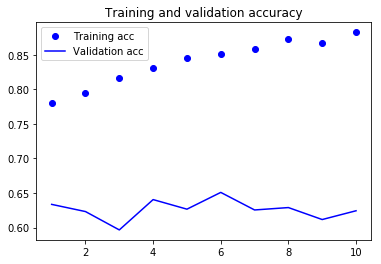

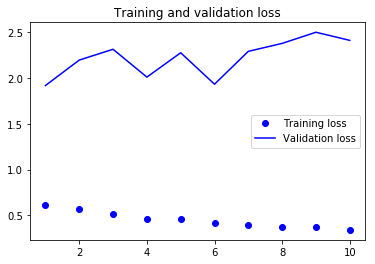

In [134]:
# Displaying curves of loss and accuracy during training
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 2 - Using Data Augmentation <a class="anchor" id="section2"> </a>

You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We’re now going to work with a new one, specific to computer vision and used almost universally when processing images with deep-learning models: data augmentation.

Overfitting is caused by having too few samples to learn from, rendering you unable
to train a model that can generalize to new data. Given infinite data, your model
would be exposed to every possible aspect of the data distribution at hand: you would
never overfit. Data augmentation takes the approach of generating more training data
from existing training samples, by augmenting the samples via a number of random
transformations that yield believable-looking images. The goal is that at training time,
your model will never see the exact same picture twice. This helps expose the model
to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to
be performed on the images read by the ImageDataGenerator instance.

Note that the validation data and the set data shouldn’t be augmented!

Defining a new convnet that includes dropout:

In [135]:
# Instantiating a small convnet
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                                    input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Dropout(0.5))
# Adding a classifier on top of the convnet
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(5, activation='softmax'))

# model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),  
              metrics=['accuracy'])

In [136]:
# Setting up a data augmentation configuration via ImageDataGenerator
train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)
            #fill_mode='nearest')

# Rescale all images by 1/255
#train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
#test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),       
        batch_size=25,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=865,
        class_mode='categorical')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=1)



Found 2593 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Epoch 1/10
100/100 [==============================] - 95s 953ms/step - loss: 1.5933 - acc: 0.2644 - val_loss: 1.5675 - val_acc: 0.3145
Epoch 2/10
100/100 [==============================] - 90s 896ms/step - loss: 1.5496 - acc: 0.3336 - val_loss: 1.5117 - val_acc: 0.4046
Epoch 3/10
100/100 [==============================] - 87s 868ms/step - loss: 1.4974 - acc: 0.3810 - val_loss: 1.4497 - val_acc: 0.4173
Epoch 4/10
100/100 [==============================] - 88s 877ms/step - loss: 1.4316 - acc: 0.4012 - val_loss: 1.3892 - val_acc: 0.4173
Epoch 5/10
100/100 [==============================] - 90s 903ms/step - loss: 1.3756 - acc: 0.4288 - val_loss: 1.3387 - val_acc: 0.4416
Epoch 6/10
100/100 [==============================] - 87s 866ms/step - loss: 1.3432 - acc: 0.4172 - val_loss: 1.2789 - val_acc: 0.4497
Epoch 7/10
100/100 [==============================] - 93s 931ms/step - loss: 1.2899 - acc: 0.4532 - val_los

In [138]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(        
        test_dir,
        shuffle = False,       # XXXXX 
        target_size=(150, 150),
        batch_size=866,
        class_mode='categorical')

#test_loss, test_acc = model.evaluate(test_images, test_labels)
test_loss, test_acc = model.evaluate_generator(test_generator, steps=1)
print('test acc:', test_acc)

Found 865 images belonging to 5 classes.
test acc: 0.4728323817253113


In [139]:
model.save('flowers_2.h5')


## 3 - Using a Pretrained Convolutional Base <a class="anchor" id="section3"></a>

A common and highly effective approach to deep learning on small image datasets is
to use a pretrained network. A pretrained network is a saved network that was previously
trained on a large dataset, typically on a large-scale image-classification task. If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task. 

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes). 

There are two ways to leverage a pre-trained network: feature extraction and fine-tuning.  Let's start with feature extraction.

#### Extracting features
Feature extraction consists of using the representations learned by a previous network
to extract interesting features from new samples. These features are then run through
a new classifier, which is trained from scratch.

As you saw previously, convnets used for image classification comprise two parts:
they start with a series of pooling and convolution layers, and they end with a densely
connected classifier. The first part is called the convolutional base of the model. In the
case of convnets, feature extraction consists of taking the convolutional base of previously trained network, running the new data through it, and training a new classifier on top of the output.

At this point, there are two ways we could proceed:

1 - Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier similar to those you have seen in the first chapters of this book. This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.

2 - Extending the model we have (conv_base) by adding Dense layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. However, for this same reason, this technique is far more expensive than the first one.

#### Features extraction - First technique
 Recording the output of conv_base on our data and using these outputs as inputs to a new model.
 
Create the Inception v3	model by calling the inception_v3() function, as shown below.

In [140]:
# Instantiating the Inceptionv3
from keras import layers
from keras import models
from keras import optimizers

from keras.applications.inception_v3 import InceptionV3

#model = models.Sequential()
conv_base = InceptionV3(weights='imagenet', 
                        include_top=False,
                        input_shape=(150,150,3))

#model.add(conv_base)
#model.add(layers.Flatten())
#model.add(layers.Dense(512, activation='relu', input_dim=3,3,2048))
#model.add(layers.Dense(5, activation='softmax'))


This is what the model looks like now after adding a densely connected classifier on top of the convolutional base build with Inceptionv3

In [141]:
# display the architecture of the composed model
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_405 (Conv2D)             (None, 74, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_377 (BatchN (None, 74, 74, 32)   96          conv2d_405[0][0]                 
__________________________________________________________________________________________________
activation_377 (Activation)     (None, 74, 74, 32)   0           batch_normalization_377[0][0]    
__________________________________________________________________________________________________
conv2d_406

The final feature map has shape (3, 3, 2048). That’s the feature on top of which we
stick the densely connected classifier. we’ll start by running instances of the previously introduced ImageDataGenerator to extract images as Numpy arrays as well as their labels. we’ll extract features from these images by calling the predict method of the conv_base model.

In [142]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/media/hi8826mo-s/BEEE-DE51/Ultimi/EDAN95_Applied_Machine_Learning/labs/flowers_split'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 1

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 2048))
    #labels = np.zeros(shape=(sample_count))         # binary class
    labels = np.zeros(shape=(sample_count, 5))       # XXXXXXXXXX multiclass 5
    
    generator = datagen.flow_from_directory(
            directory,
            target_size=(150, 150),
            batch_size=batch_size,
            class_mode='categorical')
    
    # Note that because generators yield data indefinitely in a loop,
    # we must break after every image has been seen once.
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        #print(i)
        if i * batch_size >= sample_count:
            break
        
    return features, labels
    
train_features, train_labels = extract_features(train_dir, 2595)
validation_features, validation_labels = extract_features(validation_dir, 865)
test_features, test_labels = extract_features(test_dir, 866)


Found 2593 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


NOTE: The extracted features are currently of shape (samples, 3, 3, 2048) . You’ll feed them
to a densely connected classifier, so first you must flatten them to (samples, 3*3*2048 = 18432) :

In [143]:
train_features = np.reshape(train_features, (2595, 3 * 3 * 2048))
validation_features = np.reshape(validation_features, (865, 3 * 3 * 2048))
test_features = np.reshape(test_features, (866, 3 * 3 * 2048))

At this point, you can define your densely connected classifier (note the use of drop-
out for regularization) and train it on the data and labels that you just recorded.

Training is very fast, because you only have to deal with two Dense layers—an epoch
takes less than one second even on CPU .

In [144]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=3 * 3 * 2048))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                  epochs=10,
                  batch_size=20,
                  validation_data=(validation_features, validation_labels))


Train on 2595 samples, validate on 865 samples
Epoch 1/10
2595/2595 [==============================] - 23s 9ms/step - loss: 0.9559 - acc: 0.6694 - val_loss: 0.7633 - val_acc: 0.7064
Epoch 2/10
2595/2595 [==============================] - 14s 6ms/step - loss: 0.4227 - acc: 0.8482 - val_loss: 0.6121 - val_acc: 0.7954
Epoch 3/10
2595/2595 [==============================] - 14s 5ms/step - loss: 0.2468 - acc: 0.9179 - val_loss: 0.6231 - val_acc: 0.7896
Epoch 4/10
2595/2595 [==============================] - 14s 5ms/step - loss: 0.1467 - acc: 0.9630 - val_loss: 0.6184 - val_acc: 0.8012
Epoch 5/10
2595/2595 [==============================] - 14s 5ms/step - loss: 0.0911 - acc: 0.9788 - val_loss: 0.7855 - val_acc: 0.7792
Epoch 6/10
2595/2595 [==============================] - 14s 5ms/step - loss: 0.0647 - acc: 0.9892 - val_loss: 0.6646 - val_acc: 0.8139
Epoch 7/10
2595/2595 [==============================] - 14s 5ms/step - loss: 0.0389 - acc: 0.9961 - val_loss: 0.7462 - val_acc: 0.7908
Epoch 8/

In [145]:
test_loss, test_acc = model.evaluate(test_features, test_labels)

866/866 [==============================] - 0s 510us/step


In [146]:
print('test acc:', test_acc)

test acc: 0.8198614318706697


## 4 - Second technique - Feature extraction with data augmentation <a class="anchor" id="section4"> </a>

Now, let's review the second technique for doing feature extraction, which is much slower and more expensive, but which allows us to leverage data augmentation during training: extending the conv_base model and running it end-to-end on the inputs. 

Note that this technique is in fact so expensive that you should only attempt it if you have access to a GPU: it is absolutely intractable on CPU. If you cannot run your code on GPU, then the previous technique is the way to go.

Because models behave just like layers, you can add a model (like our conv_base) to a Sequential model just like you would add a layer. So you can do the following:

In [147]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', input_dim=3*3*2048))
model.add(layers.Dense(5, activation='softmax'))

In [148]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_12 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_41 (Dense)             (None, 512)               9437696   
_________________________________________________________________
dense_42 (Dense)             (None, 5)                 2565      
Total params: 31,243,045
Trainable params: 31,208,613
Non-trainable params: 34,432
_________________________________________________________________


As you can see, the convolutional base of InceptionV3 has 21,802,784 parameters, which is
very large. The classifier you’re adding on top has 9,437,696 parameters.

###### Freezing the convulational base
Before we compile and train the model, it’s very important to freeze the convolutional base. Freezing a layer or set of layers means preventing their weights from being updated during training. If you don’t do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, you freeze a network by setting its trainable attribute to False :

In [149]:
print('This is the number of trainable weights '
'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 192


In [150]:
conv_base.trainable = False

In [151]:
conv_base.trainable = False
print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two Dense layers that we added will be
trained. That’s a total of four weight tensors: two per layer (the main weight matrix
and the bias vector). Note that in order for these changes to take effect, we must first
compile the model. If we ever modify weight trainability after compilation, we
should then recompile the model, or these changes will be ignored.

Now we can start training your model, with the same data-augmentation configuration that we used in the previous example.

In [153]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# Setting up a data augmentation configuration via ImageDataGenerator
train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

# Rescale all images by 1/255
#train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
#test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),       
        batch_size=25,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=865,
        class_mode='categorical')

# model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=2e-5),
metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=1)



Found 2593 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Epoch 1/10
100/100 [==============================] - 180s 2s/step - loss: 0.7253 - acc: 0.7383 - val_loss: 2.9460 - val_acc: 0.5399
Epoch 2/10
100/100 [==============================] - 158s 2s/step - loss: 0.7229 - acc: 0.7368 - val_loss: 2.2359 - val_acc: 0.6023
Epoch 3/10
100/100 [==============================] - 156s 2s/step - loss: 0.7223 - acc: 0.7352 - val_loss: 2.4288 - val_acc: 0.5827
Epoch 4/10
100/100 [==============================] - 158s 2s/step - loss: 0.6555 - acc: 0.7547 - val_loss: 2.9317 - val_acc: 0.5503
Epoch 5/10
100/100 [==============================] - 161s 2s/step - loss: 0.7093 - acc: 0.7506 - val_loss: 1.9994 - val_acc: 0.6208
Epoch 6/10
100/100 [==============================] - 156s 2s/step - loss: 0.6646 - acc: 0.7618 - val_loss: 3.0776 - val_acc: 0.5514
Epoch 7/10
100/100 [==============================] - 158s 2s/step - loss: 0.6743 - acc: 0.7507 - val_loss: 1.8646 - va

We can now finally evaluate this model on the test data:

In [155]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=866,
        class_mode='categorical')

#test_loss, test_acc = model.evaluate(test_images, test_labels)
test_loss, test_acc = model.evaluate_generator(test_generator, steps=1)
print('test acc:', test_acc)

Found 865 images belonging to 5 classes.
test acc: 0.6693641543388367


In [156]:
model.save('flowers_3.h5')

Let's plot our results again:

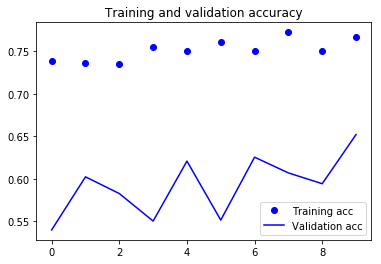

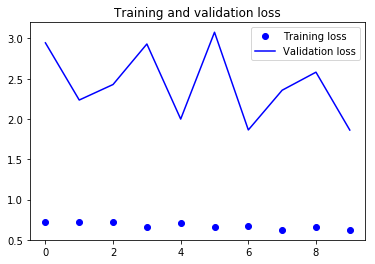

In [157]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


###### Confusion	Matrix
A much better way to evaluate the performance of a classifier is to look at the	confusion	matrix.	The general	idea is	to count the number	of times instances of class	A are classified as	class B. For example, to know the number of times the classifier confused images of	5s	with 3s, you would look	in the 5th row and 3rd column of the confusion matrix.

To compute the confusion matrix, you first need	to have	a set of predictions, so they can be compared to the actual	targets. You could make	predictions	on the test	set, but let’s keep it untouched for now (remember that	you	want to	use	the	test set only at the very end of your project, once	you	have a classifier that you are ready to	launch). Instead, you can	use	the	cross_val_predict() function:

In [159]:
#Confution Matrix 
Y_pred = model.predict_generator(validation_generator, 1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[57 16 24 28 32]
 [49 27 34 45 59]
 [49 15 14 29 35]
 [39 15 24 28 43]
 [58 22 26 36 61]]


###### Fine-tuning
Another widely used technique for model reuse, complementary to feature extraction, is fine-tuning (see figure 5.19 in Chollet). Fine-tuning consists of unfreezing a few of
the top layers of a frozen model base used for feature extraction, and jointly training
both the newly added part of the model (in this case, the fully connected classifier)
and these top layers. This is called fine-tuning because it slightly adjusts the more
abstract representations of the model being reused, in order to make them more rele-
vant for the problem at hand.

As mentioned before, it’s necessary to freeze the convolution base of InceptionV3 in order to be able to train a randomly initialized classifier on top. For the same reason, it’s only
possible to fine-tune the top layers of the convolutional base once the classifier on top
has already been trained. If the classifier isn’t already trained, then the error signal
propagating through the network during training will be too large, and the represen-
tations previously learned by the layers being fine-tuned will be destroyed. Thus the
steps for fine-tuning a network are as follow:

1 - Add your custom network on top of an already-trained base network.

2 - Freeze the base network.

3 - Train the part you added.

4 - Unfreeze some layers in the base network.

5 - Jointly train both these layers and the part you added.

We already completed the first three steps when doing feature extraction. Let’s pro-
ceed with step 4: we’ll unfreeze our conv_base and then freeze individual layers
inside it.

As a reminder, this is what your convolutional base looks like:

In [84]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_405 (Conv2D)             (None, 74, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_377 (BatchN (None, 74, 74, 32)   96          conv2d_405[0][0]                 
__________________________________________________________________________________________________
activation_377 (Activation)     (None, 74, 74, 32)   0           batch_normalization_377[0][0]    
__________________________________________________________________________________________________
conv2d_406